# Coherence Analysis & Topic Inspection

```
Author:
    Zach Wolpe
    zachcolinwolpe@gmail.com
    www.zachwolpe.com
```

Final analysis of various topic modules



 - Analyse the coherence scores computed for various values of K (topics)
 - Compute correlation between topics
 - Inspect topic common words for logical clustering
 - Visualize the model data results
 
 
 Utilizing the 20NewsGroups dataset.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import the calculated coherence data

In [130]:
import pickle 
pickle_in = open("coherence_5Topics.pkl","rb")
coherence_5Topics = pickle.load(pickle_in)

In [2]:
pickle_in = open("coherence_10Topics.pkl","rb")
coherence_10Topics = pickle.load(pickle_in)

In [191]:
pickle_in = open("coherence_15Topics.pkl","rb")
coherence_15Topics = pickle.load(pickle_in)

In [120]:
pickle_in = open("coherence_20Topics.pkl","rb")
coherence_20Topics = pickle.load(pickle_in)

In [110]:
pickle_in = open("coherence_25Topics.pkl","rb")
coherence_25Topics = pickle.load(pickle_in)

In [131]:
pickle_in = open("coherence_30Topics.pkl","rb")
coherence_30Topics = pickle.load(pickle_in)

# Create dataset of Coherence results

Transform & Merge the .plk stored computed coherence data. 

In [104]:
# create dataset of Coherence results

def data_builder(scores, model, topics, *args):
    """
    Add to dataset
    
    scores: list of scores
    topics: number of topics trained
    model 'sklearn' or 'pymc3' model used
    old_dataFrame: existing dataFrame to add to
    """  

    new_data = {
        'score': scores,
        'model': np.repeat(model, 10),
        'no. topics': np.repeat(topics, len(scores))    
    }
    
    new_data = pd.DataFrame(new_data)
    data = new_data
    
    if args:
        old_dataFrame = args[0]
        data = pd.concat([new_data, old_dataFrame])
    
    return data

In [193]:
coherence_data = data_builder(coherence_5Topics['sklearn coherence'], 'sklearn', 5)
coherence_data = data_builder(coherence_5Topics['pymc3 coherence'], 'pymc3', 5, coherence_data)

coherence_data = data_builder(coherence_10Topics['sklearn coherence'], 'sklearn', 10, coherence_data)
coherence_data = data_builder(coherence_10Topics['pymc3 coherence'], 'pymc3', 10, coherence_data)

coherence_data = data_builder(coherence_15Topics['sklearn coherence'], 'sklearn', 15, coherence_data)
coherence_data = data_builder(coherence_15Topics['pymc3 coherence'], 'pymc3', 15, coherence_data)

coherence_data = data_builder(coherence_20Topics['sklearn coherence'], 'sklearn', 20, coherence_data)
coherence_data = data_builder(coherence_20Topics['pymc3 coherence'], 'pymc3', 20, coherence_data)

coherence_data = data_builder(coherence_25Topics['sklearn coherence'], 'sklearn', 25, coherence_data)
coherence_data = data_builder(coherence_25Topics['pymc3 coherence'], 'pymc3', 25, coherence_data)

coherence_data = data_builder(coherence_30Topics['sklearn coherence'], 'sklearn', 30, coherence_data)
coherence_data = data_builder(coherence_30Topics['pymc3 coherence'], 'pymc3', 30, coherence_data)

# Graph Topic Coherence Results

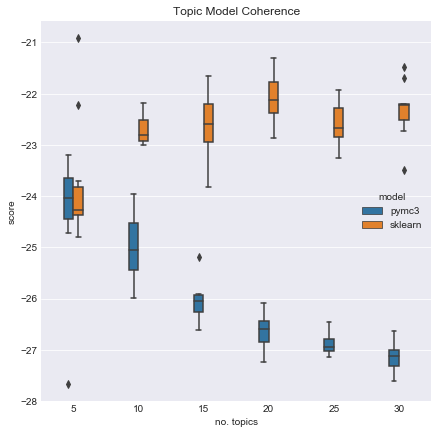

In [194]:
import seaborn as sns
plt.figure(figsize=(7,7))
#plt.ylim([-33, -20])
plt.title('Topic Model Coherence')
sns.boxplot(x='no. topics', y='score', hue='model', width=0.3, data=coherence_data);

# Test Best Result

Train various LDA models, compare the output

In [220]:
%matplotlib inline
import sys, os
%env THEANO_FLAGS=device=cpu,floatX=float64
import theano

from collections import OrderedDict
from copy import deepcopy
import numpy as np
import pandas as pd
from time import time
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.datasets import fetch_20newsgroups
import matplotlib.pyplot as plt
import seaborn as sns
from theano import shared
import theano.tensor as tt
from theano.sandbox.rng_mrg import MRG_RandomStreams

import pymc3 as pm
from pymc3 import math as pmmath
from pymc3 import Dirichlet
from pymc3.distributions.transforms import t_stick_breaking
plt.style.use('seaborn-darkgrid')

env: THEANO_FLAGS=device=cpu,floatX=float64


In [200]:
n_words = 1000

# The number of words in the vocabulary
n_words = n_words

print("Loading dataset...")
t0 = time()
dataset = fetch_20newsgroups(shuffle=True, random_state=1,
                             remove=('headers', 'footers', 'quotes'))
data_samples = dataset.data
print("done in %0.3fs." % (time() - t0))

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=n_words,
                                stop_words='english')

t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
feature_names = tf_vectorizer.get_feature_names()
print("done in %0.3fs." % (time() - t0))

Loading dataset...
done in 2.380s.
Extracting tf features for LDA...
done in 3.127s.


In [201]:
n_samples_tr = round(tf.shape[0] * 0.7) # testing on 70%
n_samples_te = tf.shape[0] - n_samples_tr
docs_tr = tf[:n_samples_tr, :]
docs_te = tf[n_samples_tr:, :]
print('Number of docs for training = {}'.format(docs_tr.shape[0]))
print('Number of docs for testing = {}'.format(docs_te.shape[0]))


n_tokens = np.sum(docs_tr[docs_tr.nonzero()])
print('Number of tokens in training set = {}'.format(n_tokens))
print('Sparsity = {}'.format(
    len(docs_tr.nonzero()[0]) / float(docs_tr.shape[0] * docs_tr.shape[1])))

Number of docs for training = 7920
Number of docs for testing = 3394
Number of tokens in training set = 384502
Sparsity = 0.0255030303030303


In [202]:
n_topics_5, n_topics_10 = 5,10

In [214]:
# For 5 Topics
from LearnParameters import LearnParameters
from time import time

t0 = time()
print('Training on 5 Topics...')
%time results_pymc3_5Topics = LearnParameters.train_pymc3(docs_te, docs_tr, n_samples_te, n_samples_tr, n_words, n_topics_5, n_tokens)
%time results_Sklearn_5Topics = LearnParameters.train_sklearn(docs_te, docs_tr, n_topics_5)
print('Done in {}'.format(time()-t0))


Training on 5 Topics...


Average Loss = 2.3783e+06: 100%|██████████| 10000/10000 [02:50<00:00, 58.79it/s]
Finished [100%]: Average Loss = 2.3799e+06


Predictive log prob (pm3) = -6.247314063128649
CPU times: user 5min 43s, sys: 28.3 s, total: 6min 11s
Wall time: 3min 27s
CPU times: user 50.6 s, sys: 297 ms, total: 50.9 s
Wall time: 44.8 s
Done in 252.26758122444153


In [247]:
# save model
# Save times dict
import pickle
pickle_out = open('results_pymc3_5Topics.pkl', 'wb')
pickle.dump(results_pymc3_5Topics, pickle_out)
pickle_out.close()
pickle_out = open('results_Sklearn_5Topics.pkl', 'wb')
pickle.dump(results_Sklearn_5Topics, pickle_out)
pickle_out.close()

In [215]:
# 10 Topics

t0 = time()
print('Training on 10 Topics... ')
%time results_pymc3_10Topics = LearnParameters.train_pymc3(docs_te, docs_tr, n_samples_te, n_samples_tr, n_words, n_topics_10, n_tokens)
%time results_Sklearn_10Topics = LearnParameters.train_sklearn(docs_te, docs_tr, n_topics_10)
print('Done in {}'.format(time()-t0))

Training on 10 Topics... 


Average Loss = 2.3815e+06: 100%|██████████| 10000/10000 [03:36<00:00, 46.58it/s]
Finished [100%]: Average Loss = 2.3831e+06


Predictive log prob (pm3) = -6.116080961873057
CPU times: user 7min 30s, sys: 34.4 s, total: 8min 4s
Wall time: 4min 28s
CPU times: user 51.7 s, sys: 374 ms, total: 52.1 s
Wall time: 46 s
Done in 314.28138494491577


In [252]:

pickle_out = open('results_pymc3_10Topics.pkl', 'wb')
pickle.dump(results_pymc3_10Topics, pickle_out)
pickle_out.close()
pickle_out = open('results_Sklearn_10Topics.pkl', 'wb')
pickle.dump(results_Sklearn_10Topics, pickle_out)
pickle_out.close()

In [250]:
t0 = time()
print('Training on 20 Topics...')
%time results_pymc3_20Topics = LearnParameters.train_pymc3(docs_te, docs_tr, n_samples_te, n_samples_tr, n_words, 20, n_tokens)
%time results_Sklearn_20Topics = LearnParameters.train_sklearn(docs_te, docs_tr, 20)
print('Done in {}'.format(time()-t0))

Training on 20 Topics...


/anaconda3/lib/python3.7/site-packages/pymc3/data.py:245: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.shared = theano.shared(data[in_memory_slc])
/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Average Loss = 2.4766e+06: 100%|██████████| 10000/10000 [05:36<00:00, 29.73it/s]
Finished [100%]: Average Loss = 2.4781e+06


Predictive log prob (pm3) = -6.128865467450396
CPU times: user 10min 54s, sys: 48.4 s, total: 11min 42s
Wall time: 7min 19s
CPU times: user 52.3 s, sys: 848 ms, total: 53.2 s
Wall time: 48.1 s
Done in 487.6331069469452


In [251]:
pickle_out = open('results_pymc3_20Topics.pkl', 'wb')
pickle.dump(results_pymc3_20Topics, pickle_out)
pickle_out.close()
pickle_out = open('results_Sklearn_20Topics.pkl', 'wb')
pickle.dump(results_Sklearn_20Topics, pickle_out)
pickle_out.close()

# 25 & 30 Topics

In [216]:
t0 = time()
print('Training on 25 Topics...')
%time results_pymc3_25Topics = LearnParameters.train_pymc3(docs_te, docs_tr, n_samples_te, n_samples_tr, n_words, 25, n_tokens)
%time results_Sklearn_25Topics = LearnParameters.train_sklearn(docs_te, docs_tr, 25)
print('Done in {}'.format(time()-t0))

Training on 25 Topics...


Average Loss = 2.5414e+06: 100%|██████████| 10000/10000 [06:58<00:00, 23.90it/s]
Finished [100%]: Average Loss = 2.543e+06


Predictive log prob (pm3) = -6.130502177465797
CPU times: user 12min 14s, sys: 55.4 s, total: 13min 10s
Wall time: 9min 10s
CPU times: user 53.9 s, sys: 616 ms, total: 54.5 s
Wall time: 48.1 s
Done in 599.1588521003723


In [217]:
t0 = time()
print('Training on 30 Topics...')
%time results_pymc3_30Topics = LearnParameters.train_pymc3(docs_te, docs_tr, n_samples_te, n_samples_tr, n_words, 30, n_tokens)
%time results_Sklearn_30Topics = LearnParameters.train_sklearn(docs_te, docs_tr, 30)
print('Done in {}'.format(time()-t0))

Training on 30 Topics...


Average Loss = 2.6014e+06: 100%|██████████| 10000/10000 [06:56<00:00, 23.99it/s]
Finished [100%]: Average Loss = 2.603e+06


Predictive log prob (pm3) = -6.191261710176405
CPU times: user 13min 2s, sys: 54.8 s, total: 13min 57s
Wall time: 9min 5s
CPU times: user 49.4 s, sys: 289 ms, total: 49.7 s
Wall time: 39.8 s
Done in 585.6262588500977


In [248]:
import pickle
pickle_out = open('results_pymc3_30Topics.pkl', 'wb')
pickle.dump(results_pymc3_30Topics, pickle_out)
pickle_out.close()
pickle_out = open('results_Sklearn_30Topics.pkl', 'wb')
pickle.dump(results_Sklearn_30Topics, pickle_out)
pickle_out.close()

# Align Topics

Once topic alignment is calculate, rearrange the rows in each Beta matrix to coincide with the correct topic order.

Utilize the hungarian algorithm for sequence.

In [306]:
def aligned_topic_order(matrix, order):
    '''
    returns: new matrix in correct order
    
    matrix: matrix to rearrage by index
    order: list of indices to follow
    '''
    
    seq = order

    new_matix = np.ones(matrix.shape)
    
    # populate with correct values
    for i in range(len(seq)):
        new_matix[i,:] = matrix[seq[i],:]

    return new_matix

In [304]:
np.array([(0, 2), (1, 4), (3, 3), (4, 1), (2, 0)])[:,0].tolist()

[0, 1, 3, 4, 2]

# Print most common words per topic

## 5 Topics

In [300]:
def print_top_words(beta, feature_names, n_top_words=10, *args):
    
    if args:
        seq = args[0]
        beta = aligned_topic_order(beta, seq)
    
    for i in range(len(beta)):
        print(("Topic #%d: " % i) + " ".join([feature_names[j]
            for j in beta[i].argsort()[:-n_top_words - 1:-1]]))      

In [307]:
# orders
seq_a = np.array([(0, 2), (1, 4), (3, 3), (4, 1), (2, 0)])[:,0]
seq_b = np.array([(0, 2), (1, 4), (3, 3), (4, 1), (2, 0)])[:,1]



print('5 Topics')
print('')
print('Pymc3:')
print_top_words(results_pymc3_5Topics['beta'], feature_names, 10, seq_a)
print('')
print('Sklearn:')
print_top_words(results_Sklearn_5Topics['beta'], feature_names, 10, seq_b)

5 Topics

Pymc3:
Topic #0: people don just think like god know time say does
Topic #1: ax max g9v b8f a86 75u 1t pl bhj 34u
Topic #2: use just like drive key know don does chip bit
Topic #3: 10 00 game team 15 11 20 year 12 play
Topic #4: edu file use program com information space mail windows available

Sklearn:
Topic #0: people don think just like know time say did said
Topic #1: ax max b8f a86 145 1d9 g9v pl 0t 34u
Topic #2: edu use com like windows thanks file does know software
Topic #3: 10 25 20 14 15 17 11 16 12 13
Topic #4: key use program space information available public government number data


In [309]:
# orders
seq_a = np.array([(0, 8), (2, 4), (3, 0), (5, 9), (6, 5), (8, 1), (7, 6), (4, 7), (1, 3), (9, 2)])[:,0]
seq_b = np.array([(0, 8), (2, 4), (3, 0), (5, 9), (6, 5), (8, 1), (7, 6), (4, 7), (1, 3), (9, 2)])[:,1]

print('10 Topics')
print('')
print('Pymc3:')
print_top_words(results_pymc3_10Topics['beta'], feature_names, 10, seq_a)
print('')
print('Sklearn:')
print_top_words(results_Sklearn_10Topics['beta'], feature_names, 10, seq_b)

10 Topics

Pymc3:
Topic #0: people god don think just like know time say said
Topic #1: windows drive use card like does problem disk thanks know
Topic #2: 00 10 11 15 20 12 17 55 16 18
Topic #3: just don good like year car game think team time
Topic #4: don use just like time need make know government think
Topic #5: ax max g9v a86 b8f 75u 1t 145 bhj 3t
Topic #6: like just water don know new used good insurance use
Topic #7: edu db thanks know mail com cs like does don
Topic #8: file edu use key information program space available data ftp
Topic #9: just don like know good does think new make ve

Sklearn:
Topic #0: people god don think just say does believe know time
Topic #1: file windows use available drive window output version disk data
Topic #2: 25 10 14 17 16 15 11 12 20 24
Topic #3: don think like just good know ve time game year
Topic #4: key government public use states president security law encryption health
Topic #5: ax max b8f a86 145 1d9 g9v pl 0t 34u
Topic #6: said peop

In [310]:
# orders
seq_a = np.array([(0, 0), (2, 10), (3, 6), (4, 2), (6, 3), (7, 12), (8, 15), (9, 14), (11, 19), (13, 17), 
                  (16, 5), (17, 13), (18, 11), (19, 7), (1, 16), (5, 8), (10, 1), (14, 4), (15, 9), (12, 18)])[:,0]
seq_b = np.array([(0, 0), (2, 10), (3, 6), (4, 2), (6, 3), (7, 12), (8, 15), (9, 14), (11, 19), (13, 17), 
                  (16, 5), (17, 13), (18, 11), (19, 7), (1, 16), (5, 8), (10, 1), (14, 4), (15, 9), (12, 18)])[:,1]

print('20 Topics')
print('')
print('Pymc3:')
print_top_words(results_pymc3_20Topics['beta'], feature_names, 10, seq_a)
print('')
print('Sklearn:')
print_top_words(results_Sklearn_20Topics['beta'], feature_names, 10, seq_b)

20 Topics

Pymc3:
Topic #0: people god don think just know like say time said
Topic #1: 00 10 11 20 55 15 12 17 16 25
Topic #2: space file information nasa gun new launch 1993 university data
Topic #3: ax max g9v 75u a86 b8f 1t bhj 3t 145
Topic #4: just like don good car year time game think team
Topic #5: like know don just good does new think edu thanks
Topic #6: know like just don good does edu thanks new think
Topic #7: know like don just good does edu new think thanks
Topic #8: know like just don does edu good think thanks new
Topic #9: like just know don does good edu new think thanks
Topic #10: just like know don does good edu thanks new think
Topic #11: like know don just edu does good think new com
Topic #12: don like know just does edu good need make got
Topic #13: don like just know edu does good actually did interested
Topic #14: use edu windows file program drive key using does card
Topic #15: like know just don good does thanks new edu think
Topic #16: like know don just 

# Visualize Results

## 20 Topics

In [311]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

In [314]:
pyLDAvis.sklearn.prepare(results_Sklearn_20Topics['lda_model'], tf, tf_vectorizer)

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.117458  0.170398       1        1  27.889681
2     -0.345914 -0.210591       2        1  14.696777
11     0.091510  0.159981       3        1   8.154951
8      0.163532 -0.112588       4        1   6.696700
6     -0.116126  0.112425       5        1   5.228617
12     0.142103 -0.048642       6        1   4.880490
5      0.190154 -0.007065       7        1   4.326347
17     0.039324  0.155949       8        1   3.973064
10    -0.347570 -0.094358       9        1   3.443685
15    -0.047650  0.032828      10        1   3.207504
3     -0.057356  0.180381      11        1   2.664758
14     0.176291 -0.081038      12        1   2.576325
16     0.145979 -0.120628      13        1   2.464420
19     0.047307 -0.150356      14        1   2.256819
9      0.134801 -0.107442      15        1   1.842823
4     -0.034970 -0.111282      16        1   1.674678
7     -0.123142  0.186714      17        1   1.667053
13    -0.130892  0.164147      18        1   1.236624
18    -0.006045 -0.162700      19        1   0.677911
1     -0.038794  0.043866      20        1   0.440773, topic_info=    Category          Freq            Term         Total  loglift  logprob
147  Default  51804.000000              ax  51804.000000  30.0000  30.0000
336  Default   2276.000000             edu   2276.000000  29.0000  29.0000
583  Default   3803.000000             max   3803.000000  28.0000  28.0000
670  Default   4237.000000          people   4237.000000  27.0000  27.0000
235  Default   1598.000000             com   1598.000000  26.0000  26.0000
148  Default   2469.000000             b8f   2469.000000  25.0000  25.0000
380  Default   1518.000000            file   1518.000000  24.0000  24.0000
325  Default   1025.000000           drive   1025.000000  23.0000  23.0000
973  Default   1141.000000         windows   1141.000000  22.0000  22.0000
931  Default   3361.000000             use   3361.000000  21.0000  21.0000
995  Default   1651.000000            year   1651.000000  20.0000  20.0000
80   Default   2002.000000             a86   2002.000000  19.0000  19.0000
792  Default    772.000000            says    772.000000  18.0000  18.0000
716  Default   1648.000000         problem   1648.000000  17.0000  17.0000
784  Default   1830.000000            said   1830.000000  16.0000  16.0000
508  Default   3686.000000            just   3686.000000  15.0000  15.0000
34   Default   1228.000000              25   1228.000000  14.0000  14.0000
540  Default   3973.000000            like   3973.000000  13.0000  13.0000
421  Default   2422.000000            good   2422.000000  12.0000  12.0000
566  Default    722.000000             mac    722.000000  11.0000  11.0000
318  Default   2721.000000            does   2721.000000  10.0000  10.0000
156  Default   1325.000000         believe   1325.000000   9.0000   9.0000
972  Default    879.000000          window    879.000000   8.0000   8.0000
25   Default   1613.000000             1d9   1613.000000   7.0000   7.0000
8    Default   1668.000000              10   1668.000000   6.0000   6.0000
401  Default   1598.000000             g9v   1598.000000   5.0000   5.0000
424  Default   1273.000000      government   1273.000000   4.0000   4.0000
128  Default    700.000000        armenian    700.000000   3.0000   3.0000
721  Default   1663.000000         program   1663.000000   2.0000   2.0000
15   Default   1743.000000             145   1743.000000   1.0000   1.0000
..       ...           ...             ...           ...      ...      ...
809  Topic20     51.790401           sense    330.312844   3.5716  -3.8467
467  Topic20     28.756201             ide    220.365947   3.3880  -4.4350
947  Topic20     56.036585           video    478.303396   3.2802  -3.7679
260  Topic20     35.427734      controller    316.844353   3.2335  -4.2264
909  Topic20     10.149350        transfer    160.624828   2.6627  -5

In [350]:
word_appearances = np.sum(docs_te.toarray(), axis=1)
word_appearances_1 = np.sum(docs_te.toarray(), axis=0)

pyLDAvis.prepare(topic_term_dists=results_pymc3_20Topics['beta'], doc_topic_dists=results_pymc3_20Topics['thetass'][0], 
                 doc_lengths=word_appearances, 
                 vocab=feature_names, 
                 term_frequency=word_appearances_1)


/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.054880  0.098403       1        1  27.135129
1     -0.045517  0.046434       2        1  24.581356
4      0.575827  0.042843       3        1  14.836724
6     -0.049113  0.015465       4        1   9.323358
3     -0.034783 -0.011620       5        1   5.667500
2      0.050162 -0.263969       6        1   5.635140
7     -0.041380  0.022407       7        1   1.773423
8     -0.039691  0.017659       8        1   1.664610
9     -0.036927  0.014360       9        1   1.231102
5     -0.040119  0.021132      10        1   1.225353
10    -0.037014  0.010395      11        1   1.140653
11    -0.035099  0.011843      12        1   1.004577
12    -0.034451  0.008317      13        1   0.910427
13    -0.033099  0.005308      14        1   0.872350
14    -0.031260  0.001982      15        1   0.742476
15    -0.029516 -0.001733      16        1   0.663363
16    -0.027235 -0.003495      17        1   0.567908
17    -0.024071 -0.007466      18        1   0.499692
18    -0.017861 -0.012921      19        1   0.316335
19    -0.013972 -0.015345      20        1   0.208523, topic_info=    Category          Freq      Term         Total  loglift  logprob
147  Default  21026.000000        ax  21026.000000  30.0000  30.0000
540  Default   1164.000000      like   1164.000000  29.0000  29.0000
508  Default   1141.000000      just   1141.000000  28.0000  28.0000
321  Default   1148.000000       don   1148.000000  27.0000  27.0000
516  Default   1026.000000      know   1026.000000  26.0000  26.0000
583  Default    898.000000       max    898.000000  25.0000  25.0000
318  Default    847.000000      does    847.000000  24.0000  24.0000
670  Default   1232.000000    people   1232.000000  23.0000  23.0000
336  Default    738.000000       edu    738.000000  22.0000  22.0000
421  Default    753.000000      good    753.000000  21.0000  21.0000
897  Default    832.000000     think    832.000000  20.0000  20.0000
0    Default    445.000000        00    445.000000  19.0000  19.0000
931  Default    968.000000       use    968.000000  18.0000  18.0000
625  Default    696.000000       new    696.000000  17.0000  17.0000
572  Default    596.000000      make    596.000000  16.0000  16.0000
900  Default    840.000000      time    840.000000  15.0000  15.0000
8    Default    514.000000        10    514.000000  14.0000  14.0000
418  Default    648.000000       god    648.000000  13.0000  13.0000
773  Default    555.000000     right    555.000000  12.0000  12.0000
620  Default    481.000000      need    481.000000  11.0000  11.0000
893  Default    375.000000    thanks    375.000000  10.0000  10.0000
380  Default    547.000000      file    547.000000   9.0000   9.0000
716  Default    478.000000   problem    478.000000   8.0000   8.0000
303  Default    516.000000       did    516.000000   7.0000   7.0000
944  Default    497.000000        ve    497.000000   6.0000   6.0000
235  Default    394.000000       com    394.000000   5.0000   5.0000
569  Default    378.000000      mail    378.000000   4.0000   4.0000
744  Default    419.000000    really    419.000000   3.0000   3.0000
954  Default    489.000000      want    489.000000   2.0000   2.0000
790  Default    520.000000       say    520.000000   1.0000   1.0000
..       ...           ...       ...           ...      ...      ...
114  Topic20      0.532805     apple    105.814353   0.8816  -6.4754
88   Topic20      0.854867  actually    271.040695   0.4138  -6.0026
81   Topic20      0.730376      able    226.680475   0.4351  -6.1600
162  Topic20      0.645137       big    172.453456   0.5845  -6.2841
95   Topic20      0.642487       ago    172.958761   0.5774  -6.2882
321  Topic20      1.458112       don   1148.338132  -0.4961  -5.4687
540  Topic20      1.455131      like   1164.380886  -0.5120  -5.4707
508  Topic20      1.316475      just   1141.760611  -0.5925  -5.5709
516  Topi

# 5 Topics

In [351]:
print('Sklearn: ')
pyLDAvis.sklearn.prepare(results_Sklearn_5Topics['lda_model'], tf, tf_vectorizer)

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.160490 -0.086549       1        1  39.848320
3     -0.160938 -0.074506       2        1  22.877315
4      0.479325 -0.082843       3        1  15.282610
0     -0.159709 -0.082874       4        1  15.008696
1      0.001812  0.326773       5        1   6.983060, topic_info=    Category          Freq       Term         Total  loglift  logprob
147  Default  52105.000000         ax  52105.000000  30.0000  30.0000
583  Default   3824.000000        max   3824.000000  29.0000  29.0000
148  Default   2483.000000        b8f   2483.000000  28.0000  28.0000
80   Default   2014.000000        a86   2014.000000  27.0000  27.0000
8    Default   1663.000000         10   1663.000000  26.0000  26.0000
15   Default   1750.000000        145   1750.000000  25.0000  25.0000
25   Default   1622.000000        1d9   1622.000000  24.0000  24.0000
401  Default   1607.000000        g9v   1607.000000  23.0000  23.0000
34   Default   1203.000000         25   1203.000000  22.0000  22.0000
682  Default   1469.000000         pl   1469.000000  21.0000  21.0000
7    Default   1359.000000         0t   1359.000000  20.0000  20.0000
28   Default   1141.000000         20   1141.000000  19.0000  19.0000
14   Default   1258.000000         14   1258.000000  18.0000  18.0000
16   Default   1132.000000         15   1132.000000  17.0000  17.0000
17   Default   1065.000000         16   1065.000000  16.0000  16.0000
10   Default    955.000000         11    955.000000  15.0000  15.0000
18   Default    922.000000         17    922.000000  14.0000  14.0000
11   Default   1002.000000         12   1002.000000  13.0000  13.0000
931  Default   3316.000000        use   3316.000000  12.0000  12.0000
509  Default   1260.000000        key   1260.000000  11.0000  11.0000
48   Default   1082.000000        34u   1082.000000  10.0000  10.0000
670  Default   4299.000000     people   4299.000000   9.0000   9.0000
13   Default    742.000000         13    742.000000   8.0000   8.0000
42   Default    929.000000         30    929.000000   7.0000   7.0000
19   Default    886.000000         18    886.000000   6.0000   6.0000
721  Default   1718.000000    program   1718.000000   5.0000   5.0000
33   Default    846.000000         24    846.000000   4.0000   4.0000
845  Default   1021.000000      space   1021.000000   3.0000   3.0000
976  Default    940.000000         wm    940.000000   2.0000   2.0000
336  Default   2243.000000        edu   2243.000000   1.0000   1.0000
..       ...           ...        ...           ...      ...      ...
53    Topic5    233.886089         39    252.637218   2.5846  -5.1018
128   Topic5    614.254014   armenian    667.057822   2.5792  -4.1362
31    Topic5    445.321519         22    486.923816   2.5724  -4.4578
44    Topic5    353.115030         31    392.390034   2.5562  -4.6898
20    Topic5    556.754061         19    619.272292   2.5553  -4.2345
36    Topic5    384.003865         26    428.211180   2.5527  -4.6059
18    Topic5    826.904190         17    922.337194   2.5525  -3.8389
63    Topic5    147.676730         55    165.968959   2.5449  -5.5616
34    Topic5   1051.339639         25   1203.504991   2.5265  -3.5988
918   Topic5    189.959242      turks    218.363920   2.5223  -5.3098
38    Topic5    344.695528         28    401.069257   2.5102  -4.7139
10    Topic5    818.651332         11    955.251681   2.5074  -3.8489
2     Topic5    150.015775         01    184.928207   2.4525  -5.5458
64    Topic5    329.629240         60    408.327952   2.4476  -4.7586
28    Topic5    895.159934         20   1141.119941   2.4189  -3.7596
16    Topic5    877.155021         15   1132.701435   2.4060  -3.7799
8     Topic5   1240.383854         10   1663.482932   2.3682  -3.4334
19    Topic5    685.153989         18    886.042920   2.4046  -4.0269
11    Topic5    754.012336         12   1002.462616   2.3769  -3.9312
14    Top

In [352]:
print('Pymc3: ')
word_appearances = np.sum(docs_te.toarray(), axis=1)
word_appearances_1 = np.sum(docs_te.toarray(), axis=0)

pyLDAvis.prepare(topic_term_dists=results_pymc3_5Topics['beta'], doc_topic_dists=results_pymc3_5Topics['thetass'][0], 
                 doc_lengths=word_appearances, 
                 vocab=feature_names, 
                 term_frequency=word_appearances_1)

Pymc3: 


/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.132880  0.039669       1        1  36.633482
3      0.132067  0.061273       2        1  19.104909
2      0.127661  0.069971       3        1  18.085124
1     -0.484480  0.011441       4        1  15.475889
4      0.091872 -0.182353       5        1  10.700596, topic_info=    Category          Freq     Term         Total  loglift  logprob
147  Default  21320.000000       ax  21320.000000  30.0000  30.0000
583  Default   1057.000000      max   1057.000000  29.0000  29.0000
8    Default    527.000000       10    527.000000  28.0000  28.0000
0    Default    350.000000       00    350.000000  27.0000  27.0000
380  Default    419.000000     file    419.000000  26.0000  26.0000
418  Default    619.000000      god    619.000000  25.0000  25.0000
402  Default    301.000000     game    301.000000  24.0000  24.0000
883  Default    271.000000     team    271.000000  23.0000  23.0000
401  Default    298.000000      g9v    298.000000  22.0000  22.0000
336  Default    642.000000      edu    642.000000  21.0000  21.0000
931  Default    925.000000      use    925.000000  20.0000  20.0000
670  Default   1264.000000   people   1264.000000  19.0000  19.0000
325  Default    340.000000    drive    340.000000  18.0000  18.0000
721  Default    357.000000  program    357.000000  17.0000  17.0000
509  Default    367.000000      key    367.000000  16.0000  16.0000
10   Default    276.000000       11    276.000000  15.0000  15.0000
995  Default    413.000000     year    413.000000  14.0000  14.0000
686  Default    224.000000     play    224.000000  13.0000  13.0000
16   Default    315.000000       15    315.000000  12.0000  12.0000
28   Default    328.000000       20    328.000000  11.0000  11.0000
11   Default    298.000000       12    298.000000  10.0000  10.0000
63   Default    183.000000       55    183.000000   9.0000   9.0000
403  Default    190.000000    games    190.000000   8.0000   8.0000
799  Default    170.000000   season    170.000000   7.0000   7.0000
214  Default    240.000000     chip    240.000000   6.0000   6.0000
397  Default    216.000000      ftp    216.000000   5.0000   5.0000
973  Default    337.000000  windows    337.000000   4.0000   4.0000
625  Default    703.000000      new    703.000000   3.0000   3.0000
845  Default    300.000000    space    300.000000   2.0000   2.0000
18   Default    214.000000       17    214.000000   1.0000   1.0000
..       ...           ...      ...           ...      ...      ...
686   Topic5    177.062998     play    224.750551   1.9964  -4.6073
52    Topic5     55.488182       38     71.902273   1.9757  -5.7677
49    Topic5     86.756870       35    112.585930   1.9743  -5.3207
951   Topic5     77.556766       vs    101.172194   1.9691  -5.4328
704   Topic5     62.852714       pp     83.233418   1.9540  -5.6430
36    Topic5     94.777375       26    126.869418   1.9432  -5.2323
2     Topic5     54.413616       01     72.875369   1.9427  -5.7872
942   Topic5     42.536499      van     57.431249   1.9346  -6.0335
20    Topic5    119.293654       19    164.918230   1.9110  -5.0022
31    Topic5    103.513562       22    142.703365   1.9138  -5.1441
32    Topic5     98.633026       23    135.661976   1.9161  -5.1924
10    Topic5    186.073856       11    276.931426   1.8372  -4.5577
8     Topic5    326.984057       10    527.414363   1.7568  -3.9939
19    Topic5    140.599841       18    203.529664   1.8650  -4.8379
18    Topic5    144.481093       17    214.460556   1.8399  -4.8107
673   Topic5    121.144382   period    179.765301   1.8402  -4.9868
16    Topic5    188.238539       15    315.829145   1.7174  -4.5461
11    Topic5    178.320580       12    298.585413   1.7194  -4.6002
28    Topic5    186.033730       20    328.853304   1.6652  -4.5579
13    Topic5    122.046177       13    194.629803   1.7682  -4.9794
61    Topic5    140.690253       50    244.